In [1]:
pip install scikit-learn

  Using cached scikit_learn-1.7.1-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.1-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.1-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.4 MB)
Using cached scipy-1.16.1-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (35.2 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 1.1 MB/s eta 0:00:0000:0100:030m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 956.4 kB/s eta 0:00:0000:010:07m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

In [25]:
df = pd.read_csv("synthetic_upi_fraud_dataset.csv")
df.head()

,transaction_id,user_id,transaction_amount,merchant_id,device_id,transaction_time,location,is_fraud,fraud_score
0,1,1683,1577.06,298,6094,2023-11-16 23:46:31,Mumbai,0,0.106549
1,2,1108,646.77,371,6139,2023-01-20 14:54:12,Hyderabad,0,0.171961
2,3,2889,2076.85,863,6978,2023-03-25 13:38:15,Chennai,0,0.010616
3,4,2207,807.37,485,6208,2023-09-08 10:14:51,Bangalore,0,0.200629
4,5,2974,735.11,648,5322,2023-05-27 08:04:48,Kolkata,0,0.253473


In [26]:
df = df.drop(["transaction_id", "transaction_time", "fraud_score"], axis=1)

In [27]:
categorical_cols = ["location", "device_id", "merchant_id", "user_id"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

In [28]:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   transaction_amount  100000 non-null  float64
 2   merchant_id         100000 non-null  int64  
 3   device_id           100000 non-null  int64  
 4   location            100000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.8 MB


In [30]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: is_fraud, Length: 100000, dtype: int64

In [31]:
z=0
o=0
for i in y:
    if i==0:
        z+=1
    else:
        o+=1
print(z , o)

95825 4175


In [32]:
scaler = StandardScaler()
X["transaction_amount"] = scaler.fit_transform(X[["transaction_amount"]])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42, class_weight="balanced"
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10, random_state=42, class_weight="balanced"
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, max_depth=8, learning_rate=0.1, 
        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), # handle imbalance
        use_label_encoder=False, eval_metric="logloss", random_state=42
    ),
}

In [35]:
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"],
        "ROC-AUC": auc
    }

Training Logistic Regression...
Training Random Forest...
Training Decision Tree...
Training XGBoost...


/home/Shiva-Arch/Desktop/UPI fraud Detection/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:41:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
comparison_df = pd.DataFrame(results).T
print("Model Comparison:")
print(comparison_df)

Model Comparison:
                     Precision    Recall  F1-score   ROC-AUC
Logistic Regression   0.933846  0.982201  0.957413  0.998913
Random Forest         0.990307  0.991909  0.991108  0.999085
Decision Tree         0.960506  0.983819  0.972022  0.991542
XGBoost               0.975962  0.985437  0.980676  0.998029


In [23]:
pip install matplotlib

  Using cached matplotlib-3.10.6-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (109 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 317.9 kB/s eta 0:00:0000:0100:01
Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4

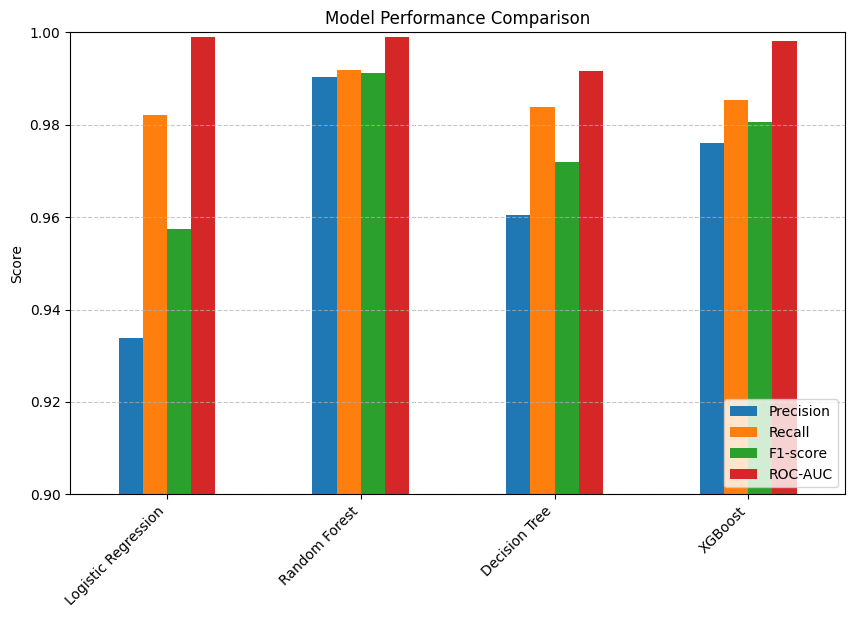

In [36]:
import matplotlib.pyplot as plt

# Plot Precision, Recall, F1-score, and ROC-AUC for each model
comparison_df.plot(kind="bar", figsize=(10,6))

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.9, 1.0)   # since your scores are all very high
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [37]:
sample_transactions = pd.DataFrame([
    {"transaction_id": 1, "user_id": 1234, "transaction_amount": 650, "merchant_id": 301, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 2, "user_id": 1234, "transaction_amount": 720, "merchant_id": 322, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 3, "user_id": 1234, "transaction_amount": 810, "merchant_id": 355, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 4, "user_id": 1234, "transaction_amount": 980, "merchant_id": 360, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 5, "user_id": 1234, "transaction_amount": 7450, "merchant_id": 401, "device_id": 7995, "location": "Delhi", "is_fraud": 1},
    {"transaction_id": 6, "user_id": 1234, "transaction_amount": 2100, "merchant_id": 405, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 7, "user_id": 1234, "transaction_amount": 8900, "merchant_id": 422, "device_id": 7997, "location": "Kolkata", "is_fraud": 1},
    {"transaction_id": 8, "user_id": 1234, "transaction_amount": 640, "merchant_id": 310, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 9, "user_id": 1234, "transaction_amount": 3100, "merchant_id": 499, "device_id": 6050, "location": "Mumbai", "is_fraud": 0},
    {"transaction_id": 10, "user_id": 1234, "transaction_amount": 5200, "merchant_id": 450, "device_id": 7989, "location": "Bangalore", "is_fraud": 1},
])


In [48]:
sample_transactions["location"] = encoder.fit_transform(sample_transactions["location"])
sample_transactions["transaction_amount"] = scaler.fit_transform(sample_transactions[["transaction_amount"]])
X_new = sample_transactions[["user_id","transaction_amount", "merchant_id", "device_id", "location"]]

In [49]:
results = sample_transactions.copy()

for model_name, model in models.items():
    preds = model.predict(X_new)
    probs = model.predict_proba(X_new)[:, 1]
    
    results[f"{model_name}_pred"] = preds
    results[f"{model_name}_prob"] = probs.round(3)

# --- 4. Show comparison ---
print("🔎 Multi-Model Inference Results:")
print(results[
    ["transaction_id", "transaction_amount", "location", "is_fraud"] +
    [col for col in results.columns if "_pred" in col or "_prob" in col]
])

🔎 Multi-Model Inference Results:
   transaction_id  transaction_amount  ...  XGBoost_pred  XGBoost_prob
0               1           -0.822929  ...             0         0.249
1               2           -0.798977  ...             0         0.264
2               3           -0.768182  ...             0         0.346
3               4           -0.710012  ...             0         0.211
4               5            1.503857  ...             0         0.005
5               6           -0.326777  ...             0         0.126
6               7            2.000010  ...             1         0.989
7               8           -0.826351  ...             0         0.225
8               9            0.015398  ...             0         0.186
9              10            0.733964  ...             0         0.025

[10 rows x 12 columns]


In [51]:
results = pd.DataFrame()
results["true_is_fraud"] = sample_transactions["is_fraud"]

for model_name, model in models.items():
    results[model_name] = model.predict(X_new)

# --- Show results ---
print("🔎 True vs Model Predictions:")
print(results)

🔎 True vs Model Predictions:
   true_is_fraud  Logistic Regression  Random Forest  Decision Tree  XGBoost
0              0                    0              0              0        0
1              0                    0              0              0        0
2              0                    0              0              0        0
3              0                    0              0              0        0
4              1                    1              0              0        0
5              0                    0              0              0        0
6              1                    1              1              0        1
7              0                    0              0              0        0
8              0                    0              0              0        0
9              1                    1              0              0        0
